In [1]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using BARON
using Gurobi
using PiecewiseLinearOpt
using VegaLite, VegaDatasets
using FileIO

  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [2]:
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Pkg.jl:570


Dict{String, VersionNumber} with 3 entries:
  "BARON"              => v"0.6.5"
  "PiecewiseLinearOpt" => v"0.3.0"
  "CPLEX"              => v"0.7.8"

In [3]:
add_key="_netzero"
innovations = CSV.File("./data-case-roadmap/innovations"*add_key*".csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./data-case-roadmap/map-ki"*add_key*".csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./data-case-roadmap/compromise"*add_key*".csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./data-case-roadmap/initial.csv",header=1,delim=",") |> DataFrame
iam_model = CSV.File("./data/iam_model.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,90.68,1,5.48,7.62,3.34,5.05,1.1,0
2,2,77.52,3,9.94,2.38,7.94,3.82,5.44,0
3,3,98.51,2,4.44,1.21,5.09,6.52,8.67,0
4,4,121.59,3,4.44,1.21,5.09,6.52,8.67,0
5,5,122.1,1,4.6,1.34,2.04,0.12,8.86,0
6,6,122.26,2,5.48,7.62,3.34,5.05,1.1,0
7,7,89.63,1,5.48,7.62,3.34,5.05,1.1,0
8,8,85.84,1,4.6,1.34,2.04,0.12,8.86,0
9,9,121.08,3,8.32,8.84,0.65,9.9,9.65,0


In [4]:
innovations[:,:name]

11-element Vector{String31}:
 "LABS from PE"
 "Pyrolysis of LDPE"
 "Pyrolysis of HDPE"
 "Pyrolysis of PP"
 "Recycling back to PLA usin Clay"
 "Alkaline hydrolysis of PLA"
 "Alcoholysis of PLA"
 "Bio Ethanol"
 "MSW pyrolysis to small olefins"
 "Source Segregation"
 "AI robot segregation"

In [5]:
#compromise[134:175,:]
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,27,LABS from PE
2,2,53,Pyrolysis of LDPE
3,3,80,Pyrolysis of HDPE
4,4,107,Pyrolysis of PP
5,5,133,Recycling back to PLA usin Clay
6,6,156,Alkaline hydrolysis of PLA
7,7,175,Alcoholysis of PLA
8,8,202,Bio-Ethanol
9,9,231,MSW pyrolysis to small olefins


In [6]:
innovations[!,:Cost_per_RL].=100
innovations[5:7,:Cost_per_RL].=150
compromise[157:175,:GHG_ElecInd].-=1
#compromise[157:175,:OCost].+=2
compromise[28:80,:GHG_ElecInd].+=2
compromise[30,:GHG_ElecInd]-=2
compromise[56,:GHG_ElecInd]-=2
innovations


,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,100,1,5.48,7.62,3.34,5.05,1.1,0
2,2,100,3,9.94,2.38,7.94,3.82,5.44,0
3,3,100,2,4.44,1.21,5.09,6.52,8.67,0
4,4,100,3,4.44,1.21,5.09,6.52,8.67,0
5,5,150,1,4.6,1.34,2.04,0.12,8.86,0
6,6,150,2,5.48,7.62,3.34,5.05,1.1,0
7,7,150,1,5.48,7.62,3.34,5.05,1.1,0
8,8,100,1,4.6,1.34,2.04,0.12,8.86,0
9,9,100,3,8.32,8.84,0.65,9.9,9.65,0


innovations[!,:Cost_per_RL].=100
innovations[5:7,:Cost_per_RL].=200
for k in 134:175
    if compromise[k,:GHG_ElecInd]>compromise[k,:GWP]
        compromise[k,:GHG_ElecInd]-=0.85*(compromise[k,:GHG_ElecInd]-compromise[k,:GWP])
    else
        compromise[k,:GHG_ElecInd]-=0.45*(compromise[k,:GHG_ElecInd])
    end
end
innovations

In [7]:

compromise[157:158,2:9]

,i,GWP,Theta,Per_Recy,Per_Comp,GHG_ElecInd,GHG_Transport,OCost
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,7,2.1106,0.7541,0.297765,0.3383,3.6613,1.9388,3.5724
2,7,2.1106,0.7541,0.297765,0.3383,3.6613,1.9388,3.5724


In [8]:

mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,27,LABS from PE
2,2,53,Pyrolysis of LDPE
3,3,80,Pyrolysis of HDPE
4,4,107,Pyrolysis of PP
5,5,133,Recycling back to PLA usin Clay
6,6,156,Alkaline hydrolysis of PLA
7,7,175,Alcoholysis of PLA
8,8,202,Bio-Ethanol
9,9,231,MSW pyrolysis to small olefins


In [9]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


give_sorted (generic function with 1 method)

In [10]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],digits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],digits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),digits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

1×5 Matrix{Int64}:
 1  2  3  4  5

In [11]:
inn_reg = CSV.File("./data-case-roadmap/inn_reg.csv",header=1,delim=",") |> DataFrame
inn_xrang = CSV.File("./data-case-roadmap/inn_xrang.csv",header=1,delim=",") |> DataFrame
inn_yrang = CSV.File("./data-case-roadmap/inn_yrang.csv",header=1,delim=",") |> DataFrame
inn_yrang[!,"Y0"]=-1*(innovations[!,"RL"].-5)
inn_yrang

,Column1,Y0,Y1,Y2,Y3,Y4,Y5
,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,1,4,2.96233,1.78618,1.01055,0.493483,0.145717
2,2,2,1.69011,1.05239,0.620783,0.283513,0.0943647
3,3,3,2.12068,1.23878,0.674932,0.321733,0.107229
4,4,2,2.12068,1.23878,0.674932,0.321733,0.107229
5,5,4,2.71009,1.64801,0.970451,0.514345,0.209507
6,6,3,2.17669,1.34348,0.779775,0.399888,0.145554
7,7,4,2.53612,1.45037,0.800682,0.375111,0.116677
8,8,4,1.94289,1.18059,0.671253,0.339467,0.143052
9,9,2,2.1622,1.32895,0.800294,0.458035,0.214698


In [12]:
tau=[0,5,10,15,20,25,30]

7-element Vector{Int64}:
  0
  5
 10
 15
 20
 25
 30

In [13]:
initial

,k,i,GWP,Theta,Per_Recycl,Per_Comp,Ocost
,Int64,Int64,Int64,Float64,Float64,Int64,Float64
1,0,0,8,0.15,0.12,0,3.2


In [14]:
iam_model[!,:SSP2_26]=[1;0.709400568;0.338927654;0.167450131;0.040623854;-0.007550004]
iam_model[!,:SSP2_34]=[1
0.79201692
0.58673921
0.421703033
0.256391318
0.173374409]
iam_model[!,:SSP2_45]=[1
0.845749028
0.697764574
0.592427808
0.495805938
0.382279665]
iam_model[!,:SSP2_60]=[1
0.863384263
0.756985447
0.698647714
0.646561914
0.57321622
]
iam_model[!,:SSP2_Base]=[1
0.868368691
0.765739022
0.714737561
0.671557877
0.6156889
]
iam_model

,Yr,Back_RedFr_Elec,SSP2_26,SSP2_34,SSP2_45,SSP2_60,SSP2_Base
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,1.0,1.0,1.0,1.0,1.0,1.0
2,10,0.949785,0.709401,0.792017,0.845749,0.863384,0.868369
3,20,0.809146,0.338928,0.586739,0.697765,0.756985,0.765739
4,30,0.623735,0.16745,0.421703,0.592428,0.698648,0.714738
5,40,0.414707,0.0406239,0.256391,0.495806,0.646562,0.671558
6,50,0.331447,-0.00755,0.173374,0.38228,0.573216,0.615689


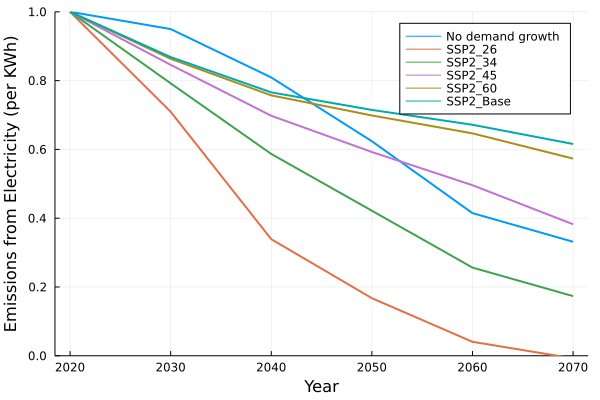

In [15]:
plot(iam_model[!,:Yr].+(2020),iam_model[!,:Back_RedFr_Elec],lw=2, label="No demand growth",ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,3],lw=2, label="SSP2_26",ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,4],lw=2, label="SSP2_34" ,ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,5],lw=2, label="SSP2_45" ,ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,6],lw=2, label="SSP2_60" ,ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,7],lw=2, label="SSP2_Base" ,ylims=(0,1))
xlabel!("Year")
ylabel!("Emissions from Electricity (per KWh)")

In [16]:
iam=2
co2factor=iam_model[!,iam+1]
co2factor=[1;0.85;0.709;0.539;0.339;0.25;0.167;0.10;0.04]

9-element Vector{Float64}:
 1.0
 0.85
 0.709
 0.539
 0.339
 0.25
 0.167
 0.1
 0.04

In [17]:

function tech_roadmap_mccormick_peicewise_iam_multipd(co2_target,circularity_target)
    
    rdmap= Model(Gurobi.Optimizer)
    #rdmap=Model(BARON.Optimizer)
    #set_optimizer_attribute(rdmap, "MaxTime", 250)
    #set_optimizer_attribute(rdmap, "DoLocal", 0)
    #set_optimizer_attribute(rdmap, "NumLoc", 0)
    set_optimizer_attribute(rdmap, "NonConvex", 2)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise),tt=1:7],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise),tt=1:7] ≤ 5)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise),tt=1:7] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations),tt=1:7],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations),tt=1:7] ≤ 5)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations),tt=1:7] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050[tt=1:7])
    
    #circularity at 2030 target
    @variable(rdmap, theta_2030[tt=1:7] ≥ 0)
    #recycled content at 2030 target
    @variable(rdmap, recycl_2030[tt=1:7] ≥ 0)
    #compostable content at 2030 target
    @variable(rdmap, comp_2030[tt=1:7] ≥ 0)
    
    
    
    #cost incured in investing to adopt
    @variable(rdmap, 0 ≤ cost_inn)
    
    #surrogate models
    @variable(rdmap,f_fit[i=1:nrow(innovations),tt=1:7] ≥ 0)
    @variable(rdmap,co2_factor[k=1:nrow(compromise),tt=1:7])
    @variable(rdmap,co2_corrected[k=1:nrow(compromise),tt=1:7])

    for i in 1:nrow(innovations)
        for tt in 1:7
            f_fit[i,tt] = piecewiselinear(rdmap, tau[tt]+ti[i,tt], Matrix(inn_xrang[!,2:ncol(inn_xrang)])[i,:],Matrix(inn_yrang[!,2:ncol(inn_yrang)])[i,:])
        end
    end
            
    
    for k in 1:nrow(compromise)
        for tt in 1:7
            co2_factor[k,tt] = (piecewiselinear(rdmap, tau[tt]+tk[k,tt], Matrix(iam_model[!,1:1])[:,1],Matrix(iam_model[!,2:7])[:,iam]))
    
        end
    end
    
    #old method when fraction of emission was specified
    #@constraint(rdmap, [k=1:nrow(compromise),tt=1:7], co2_corrected[k,tt] == 
    #    compromise[k,3]*((1-compromise[k,7]) + compromise[k,7]*(co2_factor[k,tt])))
    
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], co2_corrected[k,tt] == 
        compromise[k,3]-(compromise[k,7]*(1-co2_factor[k,tt])))
    
    #Constraints
    
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1,tt=1:7], sum(yk[k,tt] for k=1:mapki[i,2])≤ yi[i,tt])
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], sum(yk[k,tt] for k=mapki[i-1,2]:mapki[i,2])≤ yi[i,tt])
    #@constraint(rdmap,[k=2:nrow(compromise),tt=1:7],tk[k-1,tt]==tk[k,tt])
    
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1,tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:7], 5*yi[i,tt] ≥ ti[i,tt])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], 5*yk[k,tt] ≥ tk[k,tt])
    
    #@constraint(rdmap,[k=1:nrow(compromise),tt=2:7],sum(w2k[k,tt] for k in 1:nrow(compromise))*(yk[k,tt]-yk[k,tt-1])≤tk[k,tt])
    
    
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:6], yi[i,tt+1] ≥ yi[i,tt])
    @constraint(rdmap, [i=1:nrow(mapki),tt=2:7],ti[i,tt]≤ 5*( yi[i,tt]-yi[i,tt-1]))
    
    #if compromise chosen across boundary tk=0
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5*( yk[k,tt]-yk[k,tt-1]))
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5000*( xk[k,tt]-xk[k,tt-1]))
    #time of change has to be same
    #=   
    @variables(rdmap,begin 
                    u1[k=1:nrow(compromise),tt=2:7], Bin
                    u2[k=1:nrow(compromise),tt=2:7], Bin
                    u0[k=1:nrow(compromise),tt=2:7], Bin
        end)
    
    
    for i in 2:nrow(mapki)
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    end
    
    i=1
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])  
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    =#  
    
    
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≤ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≤ tk[k])
    
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], yk[k,tt] ≥ xk[k,tt])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1i
    @constraint(rdmap,[tt=1:7], sum(xk[k,tt] for k in 1:nrow(compromise)) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    #@constraint(rdmap,[tt=6:7],co2_2050[tt]==sum(xk[k,tt]*co2_corrected[k,tt] for k in 1:nrow(compromise))
    #    + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3])
    
    @constraint(rdmap,[tt=6:7],co2_2050[tt]==sum(xk[k,tt]*co2_corrected[k,tt] for k in 1:nrow(compromise))
        +(1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3])
        #+ (5*initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
        #            for k in 1:nrow(compromise))/5))
    
    #+ (initial[1,3])*(sum(sum(xk[k,tt-1] for k in 1:nrow(compromise))*tk[k,tt]-
    #(sum(xk[k,tt-1] for k in 1:nrow(compromise))*tk[k,tt]-5*sum(xk[k,tt-1] for k in 1:nrow(compromise)))
    #for k in 1:nrow(compromise))))
    
    #@constraint(rdmap, [k=1:nrow(compromise),tt=1:6], xk[k,tt+1] ≥ xk[k,tt])
    
    #tk < 30
    #@variable(rdmap, zk_2030[k=1:nrow(compromise)], Bin)
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*(1-zk_2030[k]) ≥ tk[k]-40)
    
    #circularity at 2030 target
    #@constraint(rdmap, theta_2030==sum(xk[k]*compromise[k,4]*(zk_2030[k]) for k in 1:nrow(compromise))
    #   + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,4])
    
    #circularity at 2030 target
    @constraint(rdmap,[tt=3:7], theta_2030[tt]==sum(xk[k,tt]*compromise[k,4] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,4])
    
    #recyclable content at 2030 target
    @constraint(rdmap,[tt=3:7], recycl_2030[tt]==sum(xk[k,tt]*compromise[k,5] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,5])
    
    #compostable at 2030 target
    @constraint(rdmap,[tt=3:7], comp_2030[tt]==sum(xk[k,tt]*compromise[k,6] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,6])
    
    
    #Time evolution of innovation
   
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    @variable(rdmap,0 ≤ w1k[k=1:nrow(compromise),tt=2:7])
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≥ 5*xk[k,tt-1]+tk[k,tt]-5)
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≤ 5*xk[k,tt-1])
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≤ tk[k,tt])
    
    @variable(rdmap,0 ≤ w2k[k=1:nrow(compromise),tt=1:7])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≥ 5*xk[k,tt]+tk[k,tt]-5)
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≤ 5*xk[k,tt])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≤ tk[k,tt])
    
    
    
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5-tk[k,tt])*xk[k,tt]*
    #                        (initial[1,3]-co2_corrected[k,tt]) for k in 1:nrow(compromise)) for tt in 1:6))
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5*xk[k,tt]-wk[k,tt])*(initial[1,3]-co2_corrected[k,tt]) 
    #                for k in 1:nrow(compromise)) for tt in 1:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                    -sum(sum(((w1k[k,tt]-5*xk[k,tt-1])*co2_corrected[k,tt-1])+(w2k[k,tt]*co2_corrected[k,tt])
    #                    + 5*initial[1,3]*(sum(xk[k,tt-1] for k in 1:nrow(compromise))-sum(xk[k,tt] for k in 1:nrow(compromise)))
    #                    for k in 1:nrow(compromise)) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                -sum(sum(((w1k[k,tt]-5*xk[k,tt-1])*co2_corrected[k,tt-1])-(w2k[k,tt]*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) - 5*(initial[1,3])*(sum(xk[k,tt-1] for k in 1:nrow(compromise))
    #                -sum(xk[k,tt] for k in 1:nrow(compromise))) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) + 5*(initial[1,3])*(sum(xk[k,tt-1] for k in 1:nrow(compromise))
    #                -sum(xk[k,tt] for k in 1:nrow(compromise))) for tt in 2:7))
     
    
    #correct one
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) for tt in 2:7) + 
    #                sum(5*(initial[1,3])*(sum(w1k[k,tt]-(w2k[k,tt]-5*xk[k,tt])
    #                for k in 1:nrow(compromise))/5) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*(1-sum(xk[k,1] for k in 1:nrow(compromise)))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) for tt in 2:7) + 
    #                sum(5*(initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
    #                for k in 1:nrow(compromise))/5) for tt in 2:7))
    
    
    #integral approximator of CO2
    @variable(rdmap, co2_tot)
    @variable(rdmap, tt_tau[tt=1:7])
    
    
    @constraint(rdmap, co2_tot == 5*initial[1,3]*(1-sum(xk[k,1] for k in 1:nrow(compromise)))
                    +sum(sum(xk[k,tt-1]*co2_corrected[k,tt-1]*5 for k in 1:nrow(compromise))*1.05^(-1*tau[tt]) for tt in 2:7) + 
                    sum(5*(initial[1,3])*(1-sum(xk[k,tt-1] for k in 1:nrow(compromise)))*1.05^(-1*tau[tt]) for tt in 2:7))
    
    
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*(1-sum(xk[k,1] for k in 1:nrow(compromise)))
    #                +sum(sum(sum(xk[k,tt-1]*co2factor[tt] for k in 1:nrow(compromise))*w2k[k,tt]*1.05^(-1*tau[tt])  + 
    #                + sum(xk[k,tt]*co2factor[tt] for k in 1:nrow(compromise))*(5*xk[k,tt]-w2k[k,tt])*1.05^(-1*tau[tt]) for k in 1:nrow(compromise)) for tt in 2:7)+
    #                sum(5*(initial[1,3])*(1-sum(xk[k,tt-1] for k in 1:nrow(compromise)))*1.05^(-1*tau[tt]) for tt in 2:7))
    
    
    
    @variable(rdmap,comp[tt=2:7])
    #@constraint(rdmap,[tt=2:7],comp[tt]==sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise))  + 
    #                5*(initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
    #                for k in 1:nrow(compromise))/5) )
        
    #@constraint(rdmap, 120*0.001*co2_tot ≤ 360)
    

    #setting target for 2050 co2 pledge
    @constraint(rdmap, [tt=6:7], co2_2050[tt] .≤ co2_target)
    
    #setting target for 2030 circularity pledge
    #@constraint(rdmap, theta_2030 ≥ 0.72)
    
    #setting target for 2030 recycl pledge
    #@constraint(rdmap,[tt=3:7], recycl_2030[tt] + comp_2030[tt] ≥ circularity_target)
    @constraint(rdmap,[tt=3:7], theta_2030[tt] ≥ circularity_target)
    
    #setting target for 2030 comp pledge
    #@constraint(rdmap, comp_2030 ≥ 0.45)
    
    #@constraint(rdmap,[k=1:25,tt=3:7],tk[k,tt]==0)


    #investment cost
    @constraint(rdmap, cost_inn == sum(sum(ci[i]*((yi[i,tt]-yi[i,tt-1])*f_fit[i,tt])
                for i in 1:nrow(innovations)) for tt in 2:7) + sum(ci[i]*(yi[i,1]*f_fit[i,1]) for i in 1:nrow(innovations)))
    
    #operating cost
    @variable(rdmap,cost_op ≥ 0)
    @constraint(rdmap,cost_op == sum(sum(xk[k,tt]*compromise[k,9]*1.05^(-1*tau[tt]) for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,7]*1.05^(-1*tau[tt]) for tt in 1:7))

    
    
    @constraint(rdmap, [i=1:nrow(innovations),tt=1:7],s[i,tt]==f_fit[i,tt])
    
    #@constraint(rdmap,[i=9:11,tt=1:3],yi[i,tt]==0)
    #@constraint(rdmap,[i=1,tt=1:7],yi[i,tt]==0)
    #@variable(rdmap, y1, Bin)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(y1*(2*t/50)+(1-y1)*(3*t/50))) for i in 1:nrow(innovations)))
    
    #@constraint(rdmap,[i=1:nrow(innovations)],sum(yi[i,tt] for tt=1:7)≥1)
    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    #120*0.001*co2_tot+
    @objective(rdmap,Min,120*0.001*co2_tot+0.005*cost_inn+cost_op)
    #120*0.001*co2_tot+
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    #print(rdmap)
    optimize!(rdmap)
    print(termination_status(rdmap))
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot), JuMP.value.(cost_op), JuMP.value.(co2_corrected), JuMP.value.(co2_factor), JuMP.value.(comp),JuMP.value.(w2k)
end




tech_roadmap_mccormick_peicewise_iam_multipd (generic function with 1 method)

In [19]:
iam=2
yk, tk, xk, yi, ti, s, co2, costInn, co2tot, ocost,co2fac, cc, comp1,w2k=tech_roadmap_mccormick_peicewise_iam_multipd(0,1)
yi
#0.5,0.6; iam=2

Academic license - for non-commercial use only - expires 2023-10-21
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 34127 rows, 32739 columns and 123420 nonzeros
Model fingerprint: 0xa76accc9
Model has 4 quadratic constraints
Variable types: 24927 continuous, 7812 integer (7812 binary)
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  QMatrix range    [1e+00, 1e+02]
  QLMatrix range   [1e+00, 7e+01]
  Objective range  [5e-03, 1e+00]
  Bounds range     [8e-03, 5e+00]
  RHS range        [3e-02, 3e+01]
  QRHS range       [8e+00, 2e+02]
Presolve removed 11658 rows and 15179 columns
Presolve time: 0.30s
Presolved: 30406 rows, 19579 columns, 134370 nonzeros
Presolved model has 1876 bilinear constraint(s)
Variable types: 15696 continuous, 3883 integer (3883 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

11×7 Matrix{Float64}:
 0.0  0.0   1.0  1.0   1.0   1.0   1.0
 0.0  0.0  -0.0  0.0   0.0  -0.0   0.0
 0.0  0.0   0.0  0.0   0.0  -0.0   0.0
 0.0  0.0   0.0  0.0   0.0   0.0   0.0
 0.0  0.0   0.0  0.0   0.0   0.0   0.0
 0.0  0.0   0.0  0.0   0.0   1.0   1.0
 0.0  0.0   0.0  0.0  -0.0   0.0   0.0
 1.0  1.0   1.0  1.0   1.0   1.0   1.0
 0.0  0.0   0.0  0.0   0.0   0.0   0.0
 0.0  0.0   0.0  0.0   0.0   0.0  -0.0
 0.0  0.0   0.0  0.0   0.0   0.0   0.0

In [20]:

costInn,co2tot,ocost

(293.0875063386593, 28.903243396553925, 3.0945448812887846)

In [21]:
0.005*costInn,120*0.001*co2tot,ocost

(1.4654375316932966, 3.468389207586471, 3.0945448812887846)

In [22]:
round.([0.005*costInn*100,120*0.001*co2tot*100,ocost*100],digits=4)

3-element Vector{Float64}:
 146.5438
 346.8389
 309.4545

In [23]:
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,27,LABS from PE
2,2,53,Pyrolysis of LDPE
3,3,80,Pyrolysis of HDPE
4,4,107,Pyrolysis of PP
5,5,133,Recycling back to PLA usin Clay
6,6,156,Alkaline hydrolysis of PLA
7,7,175,Alcoholysis of PLA
8,8,202,Bio-Ethanol
9,9,231,MSW pyrolysis to small olefins


In [24]:
function plotall(iam1,co2_target,theta_target,key_val)
    iam=iam1
    yk, tk, xk, yi, ti, s, co2, costInn, co2tot, ocost,co2fac, cc, comp1,w2k=tech_roadmap_mccormick_peicewise_iam_multipd(co2_target,theta_target)
    output_key="_"*names(iam_model)[iam1+1]*key_val
    want_save=1
end
    



plotall (generic function with 1 method)

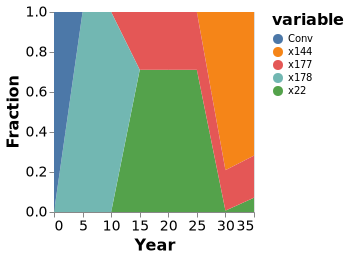

In [25]:

transpose(xk)
df1=DataFrame(xk',:auto)
df1=df1[!, any.(>(0), eachcol(df1))]
sNames="compromise ".*names(df1)
df1[!,:Year] = 5*collect(1:7)
df1[!,:Conv] = zeros(7)
push!(df1,zeros(size(df1)[2]))
df1[8,:Conv]=1
#rename!(df1,[:x28,:x29,:x30,:x44,:x48] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df1,[:x159,:x163] .=> [:alcPLA_minLCC,:alcPLA_3])
comp=df1 |> stack |> @vlplot(:area, x=:Year, y={:value, stack=:zero, title="Fraction"}, color="variable:n",legend=:sNames,
    config={axis= {labelFontSize=14,titleFontSize= 16},legend={titleFontSize=16}}) 
#save("./result-case-roadmap/compromise-netzero.svg", comp)
#comp






In [295]:
compromise[28:30,:]

,k,i,GWP,Theta,Per_Recy,Per_Comp,GHG_ElecInd,GHG_Transport
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,28,2,4.7054,0.8751,0.297765,0.0,3.2905,0.3335
2,29,2,2.5118,0.3955,0.297765,0.0,3.2805,0.3335
3,30,2,2.9585,0.0,0.0,0.0,0.8363,0.0


In [304]:
output_key="_SSP2_26"
want_save=0

0

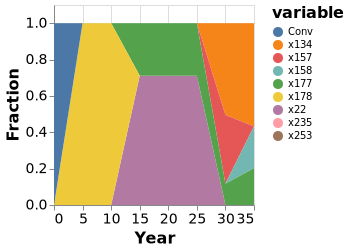

In [297]:
if want_save>0
    save("./result-case-roadmap/compromise-roadmap-"*output_key*".svg", comp)
end
comp

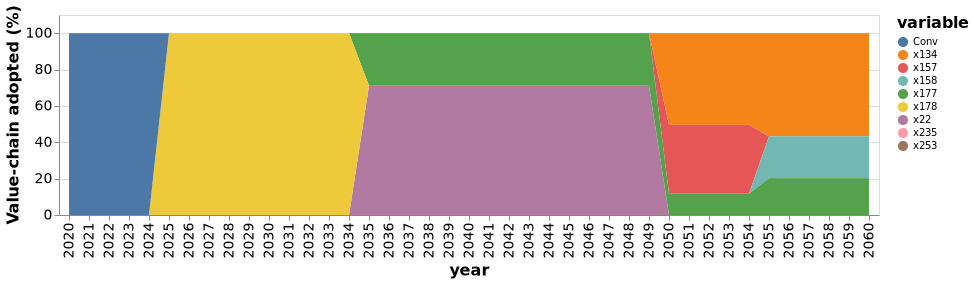

In [298]:
#only for this result

function conventional(i1,t)
    if t==7
        return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
    if t==0
        if mod(i1,5)≥mod(round.(sum(JuMP.values.(tk)[1:nrow(compromise),t+1])-0.001;digits=4),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return (1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 1
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return (1-sum_xks_atT)
    end
end

function innovation(i1,k1,t)
    if t==7
        return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
    end
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t] for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
    
end

conv=zeros(55)

conv[1]=100
inn_co2=zeros(nrow(compromise),55)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 1:55
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 26 ≤ t ≤ 30
        j=5
    elseif 31 ≤ t ≤ 35
        j=6
    else
        j=7
    end
    
    
    
    conv[t]=100*conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=100*innovation(t,k,j)
    end
end
#conv[1:5].=100

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(inn_co2,conv')',:auto)


df=df[1:41,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:41]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x269] .=> [:Conv])
#df[!,:x31]=zeros(36)
#df[!,:x38]=zeros(36)
#df[!,:x164]=zeros(36)

#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
split_yearly=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Value-chain adopted (%)"}, color="variable:n",legend=:sNames,
    config={axis= {labelFontSize=14,titleFontSize= 16},legend={titleFontSize=16}}) 
if want_save>0
    save("./result-case-roadmap/split_yearly-"*output_key*".svg", split_yearly)
end
#save("./result-case-roadmap/split_yearly-netzero.svg", split_yearly)
split_yearly



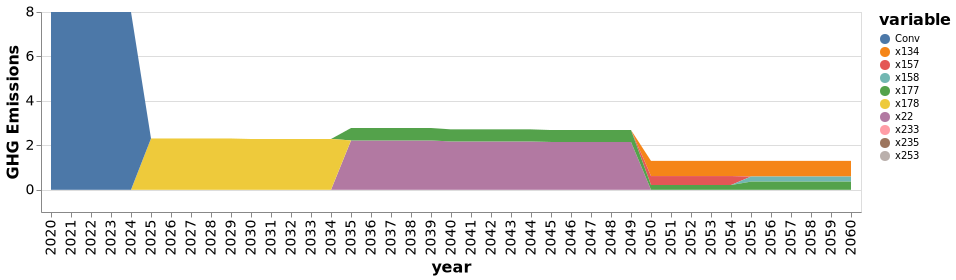

In [299]:
#only for this result

function conventional0(i1,t)
    if t==0
        if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[k1,t+1]-0.001 for k1=1:nrow(compromise));digits=2),5)
            return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
end

function conventional(i1,t)
    if t==7
        return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k=1:nrow(compromise)))
    end
    if t==0
        if mod(i1,5)≥mod(round.(sum(JuMP.values.(tk)[1:nrow(compromise),t+1])-0.001;digits=4),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return initial[1,3]*(1-sum_xks_atT)
    end
end


function innovation(i1,k1,t)
    if t==7
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1)
    end
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1)
end

conv=zeros(55)

conv[1]=initial[1,3]
inn_co2=zeros(nrow(compromise),55)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:55
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 26 ≤ t ≤ 30
        j=5
    elseif 31 ≤ t ≤ 35
        j=6
    else
        j=7
    end
    
    
    
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=innovation(t,k,j)
    end
end
conv[1:5].=initial[1,3]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(inn_co2,conv')',:auto)


df=df[1:41,:]

df=df[!, any.(!=(0), eachcol(df))]
df[!,:year]=xLabels[1:41]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x269] .=> [:Conv])
#df[!,:x104]=zeros(36)
#df[!,:x201]=zeros(36)
#df[!,:x196]=zeros(36)
#df[!,:x126]=zeros(36)
#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
co2_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="GHG Emissions"}, color="variable:n",legend=:sNames,
    config={axis= {labelFontSize=14,titleFontSize= 16},legend={titleFontSize=16}}) 

if want_save>0
    save("./result-case-roadmap/co2-roadmap-"*output_key*".svg", co2_inn)
end
co2_inn



In [300]:
compromise[134,:]

,k,i,GWP,Theta,Per_Recy,Per_Comp,GHG_ElecInd,GHG_Transport
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
134,134,6,2.7777,1.3409,0.297765,0.3383,5.0008,1.9388


In [301]:
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,27,LABS from PE
2,2,53,Pyrolysis of LDPE
3,3,80,Pyrolysis of HDPE
4,4,107,Pyrolysis of PP
5,5,133,Recycling back to PLA usin Clay
6,6,156,Alkaline hydrolysis of PLA
7,7,175,Alcoholysis of PLA
8,8,202,Bio-Ethanol
9,9,231,MSW pyrolysis to small olefins


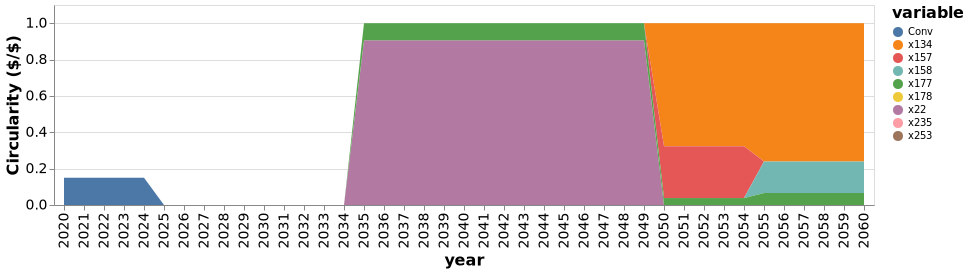

In [302]:
#=
function conventional(t)
    return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i1,k1,t)
     if mod(i1,5)>JuMP.values.(tk)[k1,t] && t<7
        t=t+1
    end
    if k1==1
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1)
    else
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1 )
    end
end
=#

function conventional(i1,t)
    if t==7
        return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
    if t==0
        if mod(i1,5)≥mod(round.(sum(JuMP.values.(tk)[1:nrow(compromise),t+1])-0.001;digits=4),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return initial[1,4]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return initial[1,4]
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return initial[1,4]*(1-sum_xks_atT)
    end
end


function innovation(i1,k1,t)
    if t==7
        if compromise[k1,4]==0 && JuMP.values.(xk)[k1,t]>0
                return 0.00001
        end
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,4]) for k=k1:k1)
    end
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.0001;digits=4),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            if compromise[k1,4]==0 && JuMP.values.(xk)[k1,t]>0
                return 0.00001
            end
            return (sum(JuMP.values.(xk)[k,t]*(compromise[k,4]) for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    if compromise[k1,4]==0 && JuMP.values.(xk)[k1,t]>0
        return 0.00001
    end
    return sum(JuMP.values.(xk)[k,t]*(compromise[k,4]) for k=k1:k1)
end





conv=zeros(55)


inn_co2=zeros(nrow(compromise),55)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 1:55
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 26 ≤ t ≤ 30
        j=5
    elseif 31 ≤ t ≤ 35
        j=6
    else
        j=7
    end
        
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        inn_co2[k,t]=innovation(t,k,j)
    end
end
#conv[1:5].=initial[1,5]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(inn_co2,conv')',:auto)


df=df[1:41,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:41]
rename!(df,[:x269] .=> [:Conv])
#rename!(df,[:x1,:x93,:x104,:x222] .=> [:Conv,:pyLDPE1,:pyLDPE11,:alcPLA6])
#df[!,:alcPLA2]=zeros(36)
#df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 
#df[!,:Conv]=zeros(36)
#df[!,:x30]=zeros(41)
#df[!,:x159]=zeros(41)
#df[!,:x201]=zeros(36)
#df[!,:x95]=zeros(36)
#rename!(df,[:x1,:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:Conv,:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])

#rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

circular_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Circularity (\$/\$)"}, color="variable:n",legend=:sNames,
    config={axis= {labelFontSize=14,titleFontSize= 16},legend={titleFontSize=16}}) 
if want_save>0
    save("./result-case-roadmap/circularity-"*output_key*".svg", circular_inn)
end
#save("./result-case-roadmap/circularity-roadmap.svg", circular_inn)
circular_inn


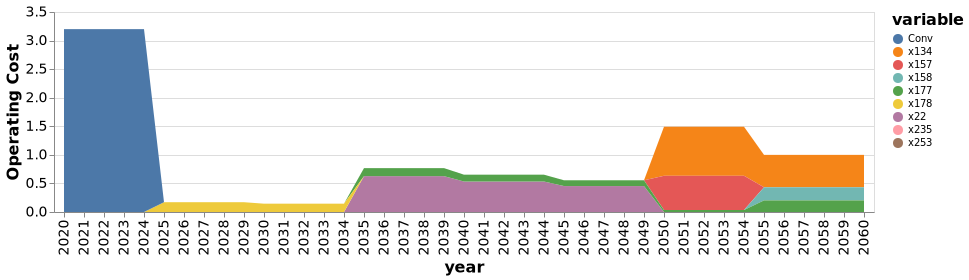

In [303]:
#only for this result

function conventional(i1,t)
    if t==7
        return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
    if t==0
        if mod(i1,5)≥mod(round.(sum(JuMP.values.(tk)[1:nrow(compromise),t+1])-0.001;digits=4),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return (1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))*initial[1,:Ocost]
        else
            return initial[1,:Ocost]
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return (1-sum_xks_atT)*initial[1,:Ocost]*0.982^(-1*tau[t])
    end
end

function innovation(i1,k1,t)
    if t==7
        return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
    end
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*compromise[k,9] for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*compromise[k,9]*0.968^(tau[t]) for k=k1:k1)
    
end




conv=zeros(55)

#onv[1]=100
inn_co2=zeros(nrow(compromise),55)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 1:55
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 26 ≤ t ≤ 30
        j=5
    elseif 31 ≤ t ≤ 35
        j=6
    else
        j=7
    end
    
    
    
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=innovation(t,k,j)
    end
end
#conv[1:5].=100

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(inn_co2,conv')',:auto)


df=df[1:41,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:41]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x269] .=> [:Conv])
#df[!,:x31]=zeros(36)
#df[!,:x38]=zeros(36)
#df[!,:x164]=zeros(36)

#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
o_cost=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Operating Cost"}, color="variable:n",legend=:sNames,
    config={axis= {labelFontSize=14,titleFontSize= 16},legend={titleFontSize=16}}) 
if want_save>0
    save("./result-case-roadmap/op_cost-"*output_key*".svg", o_cost)
end
#save("./result-case-roadmap/split_yearly-netzero.svg", split_yearly)
o_cost



In [292]:
(5*initial[1,3]*(1-sum(xk[k,1] for k in 1:nrow(compromise)))
                    +sum(sum(sum(xk[k,tt-1]*co2factor[tt] for k in 1:nrow(compromise))*w2k[k,tt]*1.05^(-1*tau[tt])  + 
                    + sum(xk[k,tt]*co2factor[tt] for k in 1:nrow(compromise))*(5*xk[k,tt]-w2k[k,tt])*1.05^(-1*tau[tt]) for k in 1:nrow(compromise)) for tt in 2:7)+
                    sum(5*(initial[1,3])*(1-sum(xk[k,tt-1] for k in 1:nrow(compromise)))*1.05^(-1*tau[tt]) for tt in 2:7))
    
(sum(sum(sum(xk[k,tt-1]*co2factor[tt] for k in 1:nrow(compromise))*w2k[k,tt]*1.05^(-1*tau[tt])  + 
                    + sum(xk[k,tt]*co2factor[tt] for k in 1:nrow(compromise))*(5*xk[k,tt]-w2k[k,tt])*1.05^(-1*tau[tt]) for k in 1:nrow(compromise)) for tt in 2:7))
    
for i in 1:7
    for k in 1:nrow(compromise)
        if w2k[k,i]>0
            println(k,"--",xk[k,i])
            println(k,"--",w2k[k,i])
            println(k,"--",tk[k,i])
            println((5-sum(w2k[k,i] for k in 1:nrow(compromise))))
            if i>1
                println(k,"--",xk[k,i-1])
                println(sum(xk[k,i-1]*co2factor[i] for k in 1:nrow(compromise))*sum(w2k[k,i] for k in 1:nrow(compromise)))
                println(sum(xk[k,i]*co2factor[i] for k in 1:nrow(compromise))*(5*xk[k,i]-w2k[k,i]))
            end
            println("--")
            
        end
    end
    println("-----------")
end 


(sum(sum(sum(xk[k,tt-1]*co2factor[tt] for k in 1:nrow(compromise))*sum(w2k[k,tt] for k in 1:nrow(compromise))*1.05^(-1*tau[tt])  + 
                    + sum(xk[k,tt]*co2factor[tt] for k in 1:nrow(compromise))*(5-sum(w2k[k,tt] for k in 1:nrow(compromise)))*1.05^(-1*tau[tt]) for k in 1:nrow(compromise)) for tt in 2:7))
  


178--1.0
178--4.999999999874334
178--4.999999999874334
1.2566570006811162e-10
--
-----------
178--1.0
178--4.999999996856371
178--4.999999996856371
3.1436293568276596e-9
178--1.0
4.249999997327915
2.6720849533035105e-9
--
-----------
22--0.7108725397326596
22--3.5543626984644003
22--4.999999999576949
3.321326325078644e-9
22--0.0
3.5449999976451796
1.4101853107462147e-10
--
177--0.2891274602673403
177--1.4456372982142731
177--4.999999991905163
3.321326325078644e-9
177--0.0
3.5449999976451796
2.213801833406137e-9
--
-----------
22--0.7108725397326596
22--3.554362698663296
22--4.999999999999993
4.358971850138005e-9
22--0.7108725397326596
2.6949999976505143
1.1968204205459189e-15
--
177--0.2891274602673404
177--1.4456372969777322
177--4.9999999875324574
4.358971850138005e-9
177--0.2891274602673403
2.6949999976505143
2.349484630403964e-9
--
-----------
22--0.7108725397326596
22--3.5543626923039557
22--4.99999998991909
1.2306550445373432e-8
22--0.7108725397326596
1.6949999958280795
2.1558170

2145.0200290024486

In [144]:
for i in 1:7
    for k in 1:nrow(compromise)
        if yk[k,i]>0
            println(k,"--",xk[k,i])
            println(k,"--",yk[k,i])
            println(k,"--",tk[k,i])
            println("--")
            #println(sum(xk[k,i]*co2fac[k,i]))
        #+(1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3]
            if i>1
                #println((initial[1,3])*(xk[k,i-1]*tk[k,i]-(xk[k,i]*tk[k,i]-5*xk[k,i])))
                println(sum((xk[k,i-1]*tk[k,i])*co2fac[k,i-1] for k=30:30))    
                println(sum((xk[k,i-1]*tk[k,i])*co2fac[k,i-1] for k=30:30))
                println(sum((xk[k,i]*tk[k,i]-5*xk[k,i])*co2fac[k,i] for k=1:nrow(compromise)))
            end
            
        end
    end
    println("-----------")
end

178--1.0
178--1.0
178--4.999999999874334
--
-----------
178--1.0
178--1.0
178--4.999999996856371
--
0.0
0.0
-7.177648866386717e-9
-----------
22--0.7108725397326596
22--1.0
22--4.999999999576949
--
0.0
0.0
-5.449053496251802e-9
177--0.2891274602673403
177--1.0
177--4.999999991905163
--
0.0
0.0
-5.449053496251802e-9
-----------
22--0.7108725397326596
22--1.0
22--4.999999999999993
--
0.0
0.0
-6.762290564031231e-9
177--0.2891274602673404
177--1.0
177--4.9999999875324574
--
0.0
0.0
-6.762290564031231e-9
-----------
22--0.7108725397326596
22--1.0
22--4.99999998991909
--
0.0
0.0
-2.988569145485848e-8
177--0.28912746026645225
177--1.0
177--4.999999984431495
--
0.0
0.0
-2.988569145485848e-8
-----------
24--0.0
24--1.0
24--5.000000000000026
--
0.0
0.0
-1.1760038386374442e-14
134--0.47905690190276684
134--1.0
134--5.000000000000045
--
0.0
0.0
-1.1760038386374442e-14
157--0.4389626789201816
157--1.0
157--4.999999999999975
--
0.0
0.0
-1.1760038386374442e-14
177--0.08198041917705155
177--1.0
177--4

In [145]:
tk

268×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [520]:
JuMP.value.(comp1)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 2:7
And data, a 6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [523]:

function tech_roadmap_mccormick_peicewise_iam_multipd(co2_target,circularity_target)
    
    #rdmap= Model(Gurobi.Optimizer)
    rdmap=Model(BARON.Optimizer)
    set_optimizer_attribute(rdmap, "MaxTime", 500)
    set_optimizer_attribute(rdmap, "DoLocal", 0)
    set_optimizer_attribute(rdmap, "NumLoc", 0)
    #set_optimizer_attribute(rdmap, "NonConvex", 2)
    #set_optimizer_attribute(rdmap, "OutputFlag", 1)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise),tt=1:7],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise),tt=1:7] ≤ 5)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise),tt=1:7] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations),tt=1:7],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations),tt=1:7] ≤ 5)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations),tt=1:7] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050[tt=1:7])
    
    #circularity at 2030 target
    @variable(rdmap, theta_2030[tt=1:7] ≥ 0)
    #recycled content at 2030 target
    @variable(rdmap, recycl_2030[tt=1:7] ≥ 0)
    #compostable content at 2030 target
    @variable(rdmap, comp_2030[tt=1:7] ≥ 0)
    
    #integral approximator of CO2
    @variable(rdmap, 400 ≥ co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0 ≤ cost_inn ≤ 1000)
    
    #surrogate models
    @variable(rdmap,f_fit[i=1:nrow(innovations),tt=1:7] ≥ 0)
    @variable(rdmap,co2_factor[k=1:nrow(compromise),tt=1:7])
    @variable(rdmap,co2_corrected[k=1:nrow(compromise),tt=1:7])

    for i in 1:nrow(innovations)
        for tt in 1:7
            f_fit[i,tt] = piecewiselinear(rdmap, tau[tt]+ti[i,tt], Matrix(inn_xrang[!,2:ncol(inn_xrang)])[i,:],Matrix(inn_yrang[!,2:ncol(inn_yrang)])[i,:])
        end
    end
            
    
    #=
    for k in 1:nrow(compromise)
        for tt in 1:7
            co2_factor[k,tt] = (piecewiselinear(rdmap, tau[tt]+tk[k,tt], Matrix(iam_model[!,1:1])[:,1],Matrix(iam_model[!,2:7])[:,iam]))
    
        end
    end
    
    #old method when fraction of emission was specified
    #@constraint(rdmap, [k=1:nrow(compromise),tt=1:7], co2_corrected[k,tt] == 
    #    compromise[k,3]*((1-compromise[k,7]) + compromise[k,7]*(co2_factor[k,tt])))
    
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], co2_corrected[k,tt] == 
        compromise[k,3]-(compromise[k,7]*(1-co2_factor[k,tt])))
    
    #Constraints
    =#
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1,tt=1:7], sum(yk[k,tt] for k=1:mapki[i,2])≤ yi[i,tt])
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], sum(yk[k,tt] for k=mapki[i-1,2]:mapki[i,2])≤ yi[i,tt])
    #@constraint(rdmap,[k=2:nrow(compromise),tt=1:7],tk[k-1,tt]==tk[k,tt])
    
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1,tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:7], 5*yi[i,tt] ≥ ti[i,tt])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], 5*yk[k,tt] ≥ tk[k,tt])
    
    #@constraint(rdmap,[k=1:nrow(compromise),tt=2:7],sum(w2k[k,tt] for k in 1:nrow(compromise))*(yk[k,tt]-yk[k,tt-1])≤tk[k,tt])
    
    
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:6], yi[i,tt+1] ≥ yi[i,tt])
    @constraint(rdmap, [i=1:nrow(mapki),tt=2:7],ti[i,tt]≤ 5*( yi[i,tt]-yi[i,tt-1]))
    
    #if compromise chosen across boundary tk=0
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5*( yk[k,tt]-yk[k,tt-1]))
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5000*( xk[k,tt]-xk[k,tt-1]))
    #time of change has to be same
    #=   
    @variables(rdmap,begin 
                    u1[k=1:nrow(compromise),tt=2:7], Bin
                    u2[k=1:nrow(compromise),tt=2:7], Bin
                    u0[k=1:nrow(compromise),tt=2:7], Bin
        end)
    
    
    for i in 2:nrow(mapki)
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    end
    
    i=1
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])  
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    =#  
    
    
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≤ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≤ tk[k])
    
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], yk[k,tt] ≥ xk[k,tt])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1i
    @constraint(rdmap,[tt=1:7], sum(xk[k,tt] for k in 1:nrow(compromise)) ≤ 1) 
    
    #circularity at 2030 target
    @constraint(rdmap,[tt=3:7], theta_2030[tt]==sum(xk[k,tt]*compromise[k,4] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,4])
    
    #recyclable content at 2030 target
    @constraint(rdmap,[tt=3:7], recycl_2030[tt]==sum(xk[k,tt]*compromise[k,5] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,5])
    
    #compostable at 2030 target
    @constraint(rdmap,[tt=3:7], comp_2030[tt]==sum(xk[k,tt]*compromise[k,6] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,6])
    
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    #@constraint(rdmap,[tt=6:7],co2_2050[tt]==sum(xk[k,tt]*co2_corrected[k,tt] for k in 1:nrow(compromise))
    #    + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3])
    
    @constraint(rdmap,[tt=6:7],co2_2050[tt]==sum(xk[k,tt]*co2factor[tt+1] for k in 1:nrow(compromise))
        +(1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3]
        + (5*initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
                    for k in 1:nrow(compromise))/5))
    
    #@constraint(rdmap, [k=1:nrow(compromise),tt=1:6], xk[k,tt+1] ≥ xk[k,tt])
    
    #tk < 30
    #@variable(rdmap, zk_2030[k=1:nrow(compromise)], Bin)
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*(1-zk_2030[k]) ≥ tk[k]-40)
    
    #circularity at 2030 target
    #@constraint(rdmap, theta_2030==sum(xk[k]*compromise[k,4]*(zk_2030[k]) for k in 1:nrow(compromise))
    #   + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,4])
    
    #Time evolution of innovation
   
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
      
    @variable(rdmap,0 ≤ wk[k=1:nrow(compromise),tt=1:7])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],wk[k,tt] ≥ 5*xk[k,tt]+tk[k,tt]-5)
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],wk[k,tt] ≤ 5*xk[k,tt])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],wk[k,tt] ≤ tk[k,tt])
    
    #@constraint(rdmap, co2_tot == sum(sum(wk[k,tt]*sum(xk[k1,tt-1]*(compromise[k1,3]-(compromise[k1,7]*(1-co2factor[tt]))) for k1 in 1:nrow(compromise))
    #            +(5*xk[k,tt]-wk[k,tt])*sum(xk[k1,tt]*(compromise[k1,3]-(compromise[k1,7]*(1-co2factor[tt+1]))) for k1 in 1:nrow(compromise)) for k in 1:nrow(compromise)) for tt in 2:7))
    
    @constraint(rdmap, co2_tot == 5*initial[1,3]*(1-sum(xk[k,1] for k in 1:nrow(compromise)))
                    +sum(sum(((tk[k,tt])*sum(xk[k1,tt-1]*(compromise[k1,3]-compromise[k1,7]*(1-co2factor[tt])) for k1 in 1:nrow(compromise)))
                    +((5-tk[k,tt])*sum(xk[k1,tt]*(compromise[k1,3]-compromise[k1,7]*(1-co2factor[tt+1])) for k1 in 1:nrow(compromise)))
                    for k in 1:nrow(compromise)) for tt in 2:7) + 
                    sum(5*(initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
                    for k in 1:nrow(compromise))/5) for tt in 2:7))
    
    
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5-tk[k,tt])*xk[k,tt]*
    #                        (initial[1,3]-co2_corrected[k,tt]) for k in 1:nrow(compromise)) for tt in 1:6))
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5*xk[k,tt]-wk[k,tt])*(initial[1,3]-co2_corrected[k,tt]) 
    #                for k in 1:nrow(compromise)) for tt in 1:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                    -sum(sum(((w1k[k,tt]-5*xk[k,tt-1])*co2_corrected[k,tt-1])+(w2k[k,tt]*co2_corrected[k,tt])
    #                    + 5*initial[1,3]*(sum(xk[k,tt-1] for k in 1:nrow(compromise))-sum(xk[k,tt] for k in 1:nrow(compromise)))
    #                    for k in 1:nrow(compromise)) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                -sum(sum(((w1k[k,tt]-5*xk[k,tt-1])*co2_corrected[k,tt-1])-(w2k[k,tt]*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) - 5*(initial[1,3])*(sum(xk[k,tt-1] for k in 1:nrow(compromise))
    #                -sum(xk[k,tt] for k in 1:nrow(compromise))) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) + 5*(initial[1,3])*(sum(xk[k,tt-1] for k in 1:nrow(compromise))
    #                -sum(xk[k,tt] for k in 1:nrow(compromise))) for tt in 2:7))
     
    
    #correct one
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) for tt in 2:7) + 
    #                sum(5*(initial[1,3])*(sum(w1k[k,tt]-(w2k[k,tt]-5*xk[k,tt])
    #                for k in 1:nrow(compromise))/5) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*(1-sum(xk[k,1] for k in 1:nrow(compromise)))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) for tt in 2:7) + 
    #                sum(5*(initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
    #                for k in 1:nrow(compromise))/5) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*(1-sum(xk[k,1] for k in 1:nrow(compromise)))
    #                +sum(sum(((xk[k,tt-1])*co2_corrected[k,tt-1]*5)
    #                for k in 1:nrow(compromise)) for tt in 2:7) + 
    #                sum(5*(initial[1,3])*(1-sum(xk[k,tt-1] for k in 1:nrow(compromise))) for tt in 2:7))
    
    
    
    
    @variable(rdmap,comp[tt=2:7])
    #@constraint(rdmap,[tt=2:7],comp[tt]==sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise))  + 
    #                5*(initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
    #                for k in 1:nrow(compromise))/5) )
        
    #@constraint(rdmap, 120*0.001*co2_tot ≤ 360)
    

    #setting target for 2050 co2 pledge
    @constraint(rdmap, co2_2050[7] .≤ co2_target)
    
    #setting target for 2030 circularity pledge
    #@constraint(rdmap, theta_2030 ≥ 0.72)
    
    #setting target for 2030 recycl pledge
    #@constraint(rdmap,[tt=3:7], recycl_2030[tt] + comp_2030[tt] ≥ circularity_target)
    @constraint(rdmap,[tt=3:7], theta_2030[tt] ≥ circularity_target)
    
    #setting target for 2030 comp pledge
    #@constraint(rdmap, comp_2030 ≥ 0.45)
    
    #@constraint(rdmap,[k=1:25,tt=3:7],tk[k,tt]==0)


    #investment cost
    @constraint(rdmap, cost_inn == sum(sum(ci[i]*((yi[i,tt]-yi[i,tt-1])*f_fit[i,tt])
                for i in 1:nrow(innovations)) for tt in 2:7) + sum(ci[i]*(yi[i,1]*f_fit[i,1]) for i in 1:nrow(innovations)))
    
    #operating cost
    @variable(rdmap, 500 ≥ cost_op ≥ 0)
    @constraint(rdmap,cost_op == sum(sum(xk[k,tt]*compromise[k,9]*0.982^(-1*tau[tt]) for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,7]*0.982^(-1*tau[tt]) for tt in 1:7))

    
    
    @constraint(rdmap, [i=1:nrow(innovations),tt=1:7],s[i,tt]==f_fit[i,tt])
    
    #@constraint(rdmap,[i=9:11,tt=1:7],yi[i,tt]==0)
    #@variable(rdmap, y1, Bin)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(y1*(2*t/50)+(1-y1)*(3*t/50))) for i in 1:nrow(innovations)))
    
    #@constraint(rdmap,[i=1:nrow(innovations)],sum(yi[i,tt] for tt=1:7)≥1)
    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    #120*0.001*co2_tot+
    @objective(rdmap,Min,120*co2_tot+0.25*cost_inn+10*cost_op)
    #120*0.001*co2_tot+
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    #print(rdmap)
    optimize!(rdmap)
    print(termination_status(rdmap))
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot), JuMP.value.(cost_op), JuMP.value.(co2_corrected), JuMP.value.(co2_factor), JuMP.values.(comp)
end




tech_roadmap_mccormick_peicewise_iam_multipd (generic function with 1 method)

In [524]:
df_tk=DataFrame(tk',:auto)
#CSV.write("./result-case-roadmap/tk", df_tk)

,x1,x2,x3,x4,x5,x6,x7,x8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,-1.42109e-14,0.0,0.0,0.0,0.0,0.0,-1.42109e-14
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [302]:
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,27,LABS from PE
2,2,53,Pyrolysis of LDPE
3,3,80,Pyrolysis of HDPE
4,4,107,Pyrolysis of PP
5,5,133,Recycling back to PLA usin Clay
6,6,156,Alkaline hydrolysis of PLA
7,7,175,Alcoholysis of PLA
8,8,202,Bio-Ethanol
9,9,231,MSW pyrolysis to small olefins


In [303]:
yi

11×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [27]:
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,27,LABS from PE
2,2,53,Pyrolysis of LDPE
3,3,80,Pyrolysis of HDPE
4,4,107,Pyrolysis of PP
5,5,133,Recycling back to PLA usin Clay
6,6,156,Alkaline hydrolysis of PLA
7,7,175,Alcoholysis of PLA
8,8,202,Bio-Ethanol
9,9,231,MSW pyrolysis to small olefins


In [28]:
xk

268×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [29]:
ti  

11×7 Matrix{Float64}:
  0.0          -2.66454e-14   0.0          …  -2.84217e-14  -1.42109e-14
  5.0           2.27374e-13   0.0              0.0          -1.42109e-14
  0.0          -5.68434e-14  -5.68434e-14      0.0          -5.68434e-14
  0.0           0.0          -7.10543e-15      0.0           0.0
  0.0          -1.42109e-14  -1.42109e-14      0.0          -4.26326e-14
 -5.68434e-14   0.0           3.55271e-15  …  -4.26326e-14  -7.10543e-14
  0.0          -4.44089e-15   0.0              0.0          -2.84217e-14
  0.0          -4.26326e-14  -4.26326e-14     -1.42109e-14   0.0
  0.0          -3.55271e-14  -7.10543e-15     -3.55271e-14  -7.10543e-14
  0.0          -3.55271e-14  -7.10543e-15     -3.55271e-14  -7.10543e-14
  0.0           0.0           0.0          …  -2.13163e-14  -2.13163e-14

In [30]:
compromise

,k,i,GWP,Theta,Per_Recy,Per_Comp,GHG_ElecInd,GHG_Transport
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,8.5782,1.3565,0.297765,0.0,3.4143,0.8678
2,2,1,2.5118,0.3955,0.297765,0.0,1.2805,0.3335
3,3,1,2.9585,0.0,0.0,0.0,0.8363,0.0
4,4,1,2.6374,0.5189,0.297765,0.0,1.2794,0.3335
5,5,1,2.6374,0.5015,0.29772,0.0,1.2969,0.3382
6,6,1,2.6374,0.5189,0.297765,0.0,1.2794,0.3335
7,7,1,2.6374,0.4931,0.288225,0.0,1.2653,0.3228
8,8,1,2.9949,0.1134,0.026505,0.0,0.8753,0.0298
9,9,1,3.8684,1.2855,0.297585,0.0008,1.4822,0.3861


In [31]:
s

11×7 Matrix{Float64}:
 4.0      3.20009  2.7975   2.80855  2.87413  3.10329  3.33245
 1.77627  1.77627  1.77064  1.84203  1.93909  2.05062  2.20556
 3.0      2.94871  2.89741  2.84612  2.82938  2.82417  2.87432
 2.0      2.2564   2.5128   2.76919  2.82938  2.82417  2.87432
 4.0      3.08606  3.29556  3.50506  3.79826  4.11937  4.48943
 3.0      3.05138  3.10276  3.15414  3.25012  3.36137  3.51844
 4.0      3.57293  3.14586  2.83526  2.83526  2.81759  2.91193
 4.0      2.30005  2.45954  2.61903  2.77851  2.96735  3.16598
 2.0      2.83366  3.13694  3.44021  3.74349  4.09244  4.48707
 2.0      2.83366  3.13694  3.44021  3.74349  4.09244  4.48707
 4.0      3.56072  3.43655  3.64844  3.86032  4.1536   4.52828

In [32]:
df1

,pyLDPE_maxTheta,pyLDPE_minGWP,pyLDPE_minLCC,pyLDPE_14,pyLDPE_18,alcPLA_minLCC
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.765627,0.0,0.0,0.0,0.0,0.234373
5,0.0,0.0,0.0,0.0,1.0,7.32053e-16
6,0.765627,0.0,0.0,0.0,0.0,0.234373
7,0.0,0.129678,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
iam_model

,Yr,Back_RedFr_Elec
,Int64,Float64
1,0,1.0
2,10,0.949785
3,20,0.809146
4,30,0.623735
5,40,0.414707
6,50,0.331447


In [165]:
sum(xk[:,7])

1.0

In [35]:
mod(6,5)

1

1

In [87]:
for i in 1:7
    for k in 1:nrow(compromise)
        if yk[k,i]>0
            println(k,"--",xk[k,i])
            println(k,"--",yk[k,i])
            println(k,"--",tk[k,i])
            println("--")
            #println(sum(xk[k,i]*co2fac[k,i]))
        #+(1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3]
            if i>1
                #println((initial[1,3])*(xk[k,i-1]*tk[k,i]-(xk[k,i]*tk[k,i]-5*xk[k,i])))
                println(sum((xk[k,i-1]*tk[k,i])*co2fac[k,i-1] for k=30:30))    
                println(sum((xk[k,i-1]*tk[k,i])*co2fac[k,i-1] for k=30:30))
                println(sum((xk[k,i]*tk[k,i]-5*xk[k,i])*co2fac[k,i] for k=1:nrow(compromise)))
            end
            
        end
    end
    println("-----------")
end

30--0.9999999999995144
30--1.0
30--4.999999996781709
--
-----------
30--0.9999999999996699
30--1.0
30--2.275852411680512
--
6.4565610831321685
6.4565610831321685
-7.577696490217795
-----------
28--0.9999999999976126
28--1.0
28--2.656633333922446
--
0.0
0.0
-9.850034900841061
-----------
28--0.8570449091616275
28--1.0
28--2.1857267110978498
--
0.0
0.0
-9.61608147632006
159--0.14295509083772637
159--1.0
159--4.999999998260376
--
0.0
0.0
-9.61608147632006
-----------
28--0.8570449091532397
28--1.0
28--2.413797029346863
--
0.0
0.0
-9.822588169561547
159--0.14295509084676036
159--1.0
159--2.4017590878731157
--
0.0
0.0
-9.822588169561547
-----------
28--0.8570449091534644
28--1.0
28--2.1094846266817995
--
0.0
0.0
-10.729275856023344
159--0.14295509084703312
159--1.0
159--2.1521374254293293
--
0.0
0.0
-10.729275856023344
-----------
48--0.07414104882459276
48--1.0
48--4.966466663408867
--
0.0
0.0
-0.006456142100684002
157--0.9258589511754073
157--1.0
157--4.997557185004322
--
0.0
0.0
-0.00645

In [122]:
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,27,LABS from PE
2,2,53,Pyrolysis of LDPE
3,3,80,Pyrolysis of HDPE
4,4,107,Pyrolysis of PP
5,5,133,Recycling back to PLA usin Clay
6,6,156,Alkaline hydrolysis of PLA
7,7,175,Alcoholysis of PLA
8,8,202,Bio-Ethanol
9,9,231,MSW pyrolysis to small olefins


In [86]:
compromise[199,:]

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
199,199,9,3.4669,0.7436,0.661689,0.196905,1.58,0.132,1.6963


In [22]:
df1

,pyLDPE_maxTheta,pyLDPE_minGWP,pyLDPE_minLCC,pyLDPE_14,pyLDPE_18,alcPLA_minLCC
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.765627,0.0,0.0,0.0,0.0,0.234373
5,0.0,0.0,0.0,0.0,1.0,7.32053e-16
6,0.765627,0.0,0.0,0.0,0.0,0.234373
7,0.0,0.129678,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
for i in 1:240
    if sum(xk[i,:])>0
        print(i)
        println(round.(xk[i,:].*co2fac[i,:];digits=2))
    end
end

157[1.63, 0.0, 0.0, 0.0, 0.0, -0.59, -0.0]
158[0.0, 1.14, 0.66, 0.18, -0.2, -0.0, -0.96]


In [87]:
for i in 1:240
    if sum(xk[i,:])>0
        print(i)
        println(round.(xk[i,:];digits=2))
    end
end

157[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
158[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.99]


In [88]:
for i in 1:240
    if sum(xk[i,:])>0
        print(i)
        println(round.(tk[i,:];digits=2))
    end
end

157[5.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0]
158[-0.0, 5.0, 5.0, 5.0, 5.0, 0.0, 4.89]


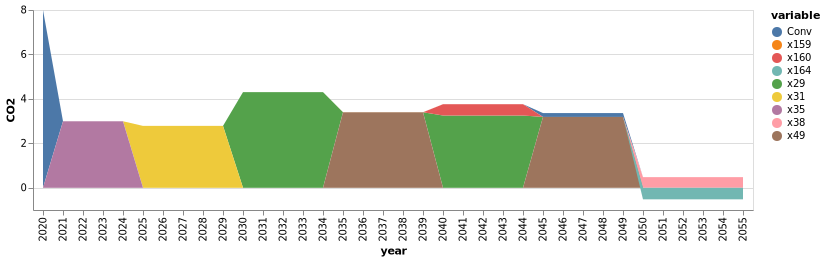

In [245]:
#only for this result

function conventional0(i1,t)
    if t==0
        if mod(i1,5)≥mod(sum(round(JuMP.values.(tk)[k1,t+1];digits=2) for k1=1:nrow(compromise)),5)
            return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
end

function conventional(i1,t)
    if t==0
        if mod(i1,5)≥mod(sum(round.(JuMP.values.(tk)[1:nrow(compromise),t+1];digits=2)),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return initial[1,3]*(1-sum_xks_atT)
    end
end


function innovation(i1,k1,t)
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1)
end

conv=zeros(51)

conv[1]=initial[1,3]
inn_co2=zeros(nrow(compromise),51)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:51
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 25 ≤ t ≤ 30
        j=5
    else
        j=6
    end
    
    
    
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=innovation(t,k,j)
    end
end
#conv[1:5].=initial[1,3]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(conv',inn_co2)',:auto)


df=df[1:36,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:36]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x1] .=> [:Conv])
#df[!,:x104]=zeros(36)
#df[!,:x201]=zeros(36)
#df[!,:x196]=zeros(36)
#df[!,:x126]=zeros(36)
#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
co2_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/co2-roadmap-netzero.svg", co2_inn)
co2_inn



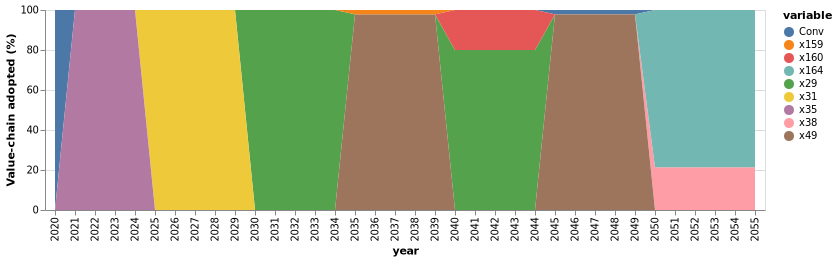

In [247]:
#only for this result

function conventional(i1,t)
    if t==0
        if mod(i1,5)≥mod(sum(round.(JuMP.values.(tk)[1:nrow(compromise),t+1];digits=2)),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return (1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return (1-sum_xks_atT)
    end
end

function innovation(i1,k1,t)
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t] for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
end

conv=zeros(51)

conv[1]=100
inn_co2=zeros(nrow(compromise),51)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:51
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 25 ≤ t ≤ 30
        j=5
    else
        j=6
    end
    
    
    
    conv[t]=100*conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=100*innovation(t,k,j)
    end
end
#conv[1:5].=initial[1,3]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(conv',inn_co2)',:auto)


df=df[1:36,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:36]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x1] .=> [:Conv])
#df[!,:x104]=zeros(36)
#df[!,:x201]=zeros(36)

#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
split_yearly=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Value-chain adopted (%)"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/split_yearly-netzero.svg", split_yearly)
split_yearly



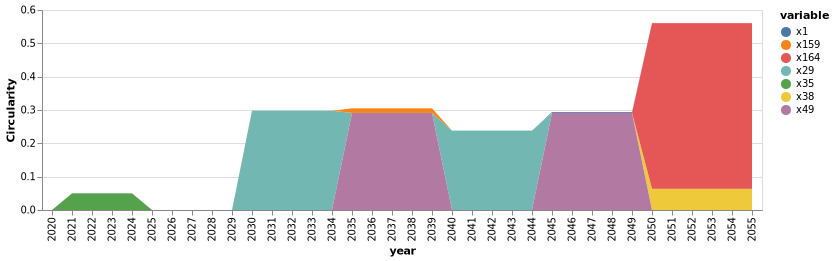

In [25]:
#=
function conventional(t)
    return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i1,k1,t)
     if mod(i1,5)>JuMP.values.(tk)[k1,t] && t<7
        t=t+1
    end
    if k1==1
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1)
    else
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1 )
    end
end
=#

function conventional(i1,t)
    if t==0
        if mod(i1,5)≥mod(sum(round.(JuMP.values.(tk)[1:nrow(compromise),t+1];digits=2)),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return initial[1,5]*(1-sum_xks_atT)
    end
end


function innovation(i1,k1,t)
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*(compromise[k,5]+compromise[k,6]) for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*(compromise[k,5]+compromise[k,6]) for k=k1:k1)
end





conv=zeros(51)


inn_co2=zeros(nrow(compromise),51)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:51
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 25 ≤ t ≤ 30
        j=5
    else
        j=6
    end
        
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        inn_co2[k,t]=innovation(t,k,j)
    end
end
#conv[1:5].=initial[1,5]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(conv',inn_co2)',:auto)


df=df[1:36,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:36]
#rename!(df,[:x1,:x93,:x104,:x222] .=> [:Conv,:pyLDPE1,:pyLDPE11,:alcPLA6])
#df[!,:alcPLA2]=zeros(36)
#df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 
#df[!,:Conv]=zeros(36)
#df[!,:x104]=zeros(36)
#df[!,:x196]=zeros(36)
#df[!,:x201]=zeros(36)
#df[!,:x95]=zeros(36)
#rename!(df,[:x1,:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:Conv,:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])

#rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

circular_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Circularity"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/circularity-roadmap.svg", circular_inn)
circular_inn


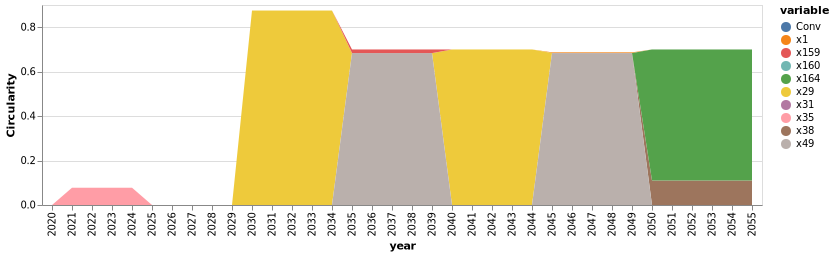

In [252]:
#=
function conventional(t)
    return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i1,k1,t)
     if mod(i1,5)>JuMP.values.(tk)[k1,t] && t<7
        t=t+1
    end
    if k1==1
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1)
    else
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1 )
    end
end
=#

function conventional(i1,t)
    if t==0
        if mod(i1,5)≥mod(sum(round.(JuMP.values.(tk)[1:nrow(compromise),t+1];digits=2)),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return initial[1,4]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return initial[1,4]*(1-sum_xks_atT)
    end
end


function innovation(i1,k1,t)
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*(compromise[k,4]) for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1];digits=2),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*(compromise[k,4]) for k=k1:k1)
end





conv=zeros(51)


inn_co2=zeros(nrow(compromise),51)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:51
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 25 ≤ t ≤ 30
        j=5
    else
        j=6
    end
        
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        inn_co2[k,t]=innovation(t,k,j)
    end
end
#conv[1:5].=initial[1,5]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(conv',inn_co2)',:auto)


df=df[1:36,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:36]
#rename!(df,[:x1,:x93,:x104,:x222] .=> [:Conv,:pyLDPE1,:pyLDPE11,:alcPLA6])
#df[!,:alcPLA2]=zeros(36)
#df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 
#df[!,:Conv]=zeros(36)
#df[!,:x104]=zeros(36)
#df[!,:x196]=zeros(36)
df[!,:Conv]=zeros(36)
df[!,:x31]=zeros(36)
df[!,:x160]=zeros(36)
#rename!(df,[:x1,:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:Conv,:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])

#rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
circular_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Circularity"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/circularity-netzero.svg", circular_inn)
circular_inn


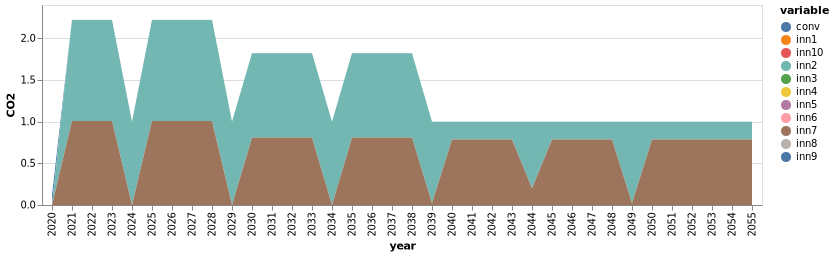

In [255]:
function conventional(t)
    return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i0,i,t)
    #if mod(i0,5)>JuMP.values.(tk)[k1,t] && t<7
    #    t=t+1
    #end
    if i==1
        s=0
        for k1 in 1:mapki[i,2]
            if mod(i0,5)>JuMP.values.(tk)[k1,t] && t<7
                t=t+1
            end
        s+=JuMP.values.(xk)[k1,t]
        end
        return s   
    else
        s=0
        for k1 in mapki[i-1,2]:mapki[i,2]
            if mod(i0,5)>JuMP.values.(tk)[k1,t] && t<7
                t=t+1
            end
        s+=JuMP.values.(xk)[k1,t]
        end
        return s   
        #return sum(JuMP.values.(xk)[k,t] for k=mapki[i-1,2]:mapki[i,2] )
    end
end

conv=zeros(51)

conv[1]=initial[1,5]
inn_co2=zeros(nrow(innovations),51)

for inn in 1:nrow(innovations)
    inn_co2[inn,1]=0
end

j=0
for i in 2:51
    if 0 ≤ i ≤ 5
        j=1
    elseif 6 ≤ i ≤ 10
        j=2
    elseif 11 ≤ i ≤ 15
        j=3
    elseif 16 ≤ i ≤ 20
        j=4
    elseif 21 ≤ i ≤ 25
        j=5
    elseif 26 ≤ i ≤ 30
        j=6
    else
        j=7
    end
        
    conv[i]=conventional(j)
    for inn in 1:nrow(innovations)
        inn_co2[inn,i]=innovation(i,inn,j)
    end
end

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df=df[1:36,:]
df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

In [40]:
#=
#cost objective
#@NLconstraint(rdmap, cost_inn == sum(sum(ci[i]*((yi[i,tt]-yi[i,tt-1])*f_fit[i,tt])
#            for i in 2:nrow(innovations)) for tt in 2:7) + sum(ci[i]*(yi[i,1]*f_fit[i,1]) for i in 1:nrow(innovations)))
#linearization
@variable(rdmap,0≤p[i=1:nrow(innovations),tt=2:7]≤5)
@constraint(rdmap,[i=1:nrow(innovations),tt=2:7],p[i,tt]≤5*(yi[i,tt]-yi[i,tt-1]))
@constraint(rdmap,[i=1:nrow(innovations),tt=2:7],p[i,tt]≤(f_fit[i,tt]))
@constraint(rdmap,[i=1:nrow(innovations),tt=2:7],p[i,tt]≥(f_fit[i,tt])-5*(1-(yi[i,tt]-yi[i,tt-1])))

@variable(rdmap,0≤q[i=1:nrow(innovations),tt=1:1]≤5)
@constraint(rdmap,[i=1:nrow(innovations),tt=1:1],q[i,tt]≤(yi[i,tt]))
@constraint(rdmap,[i=1:nrow(innovations),tt=1:1],q[i,tt]≤(f_fit[i,tt]))
@constraint(rdmap,[i=1:nrow(innovations),tt=1:1],q[i,tt]≥(f_fit[i,tt])-5*(1-(yi[i,tt])))

@constraint(rdmap,cost_inn == sum(sum(ci[i]*p[i,tt] for i in 2:nrow(innovations)) for tt in 2:7) +
                                sum(ci[i]*q[i,1] for i in 1:nrow(innovations)))

#http://yetanothermathprogrammingconsultant.blogspot.com/2008/05/multiplication-of-continuous-and-binary.html

=#


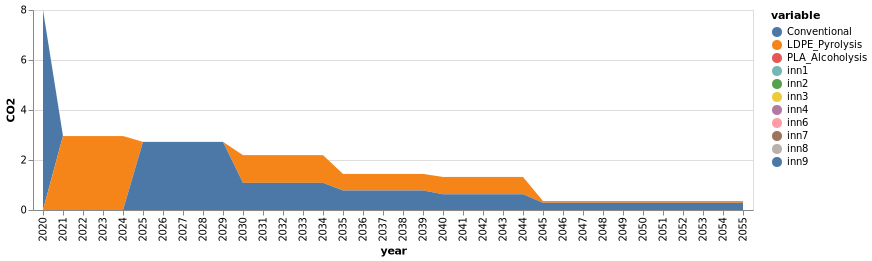

In [41]:
function conventional(t)
    return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i,t)
    if i==1
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=1:mapki[i,2])
    else
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=mapki[i-1,2]:mapki[i,2])
    end
end

conv=zeros(51)

conv[1]=initial[1,3]
inn_co2=zeros(nrow(innovations),51)

for inn in 1:nrow(innovations)
    inn_co2[inn,1]=0
end
j=0
for i in 2:51
    
    if 0 ≤ i ≤ 5
        j=1
    elseif 6 ≤ i ≤ 10
        j=2
    elseif 6 ≤ i ≤ 10
        j=3
    elseif 11 ≤ i ≤ 15
        j=4
    elseif 16 ≤ i ≤ 20
        j=5
    elseif 21 ≤ i ≤ 25
        j=6
    else
        j=7
    end
    
    conv[i]=conventional(j)
    for inn in 1:nrow(innovations)
        inn_co2[inn,i]=innovation(inn,j)
    end
end


sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df=df[1:36,:]

rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

co2_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/co2-roadmap.svg", co2_inn)
co2_inn



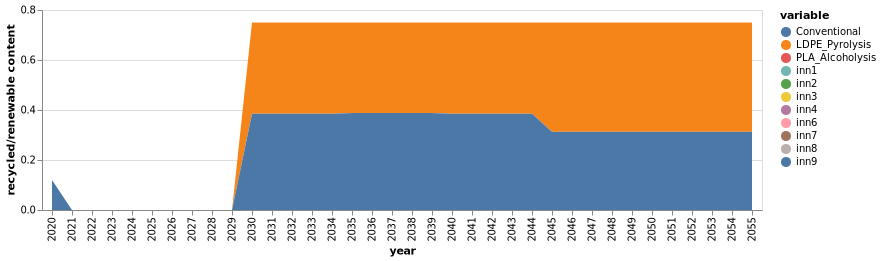

In [42]:
function conventional(t)
    return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i,t)
    if i==1
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=1:mapki[i,2])
    else
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=mapki[i-1,2]:mapki[i,2] )
    end
end

conv=zeros(51)

conv[1]=initial[1,5]
inn_co2=zeros(nrow(innovations),51)

for inn in 1:nrow(innovations)
    inn_co2[inn,1]=0
end

j=0
for i in 2:51
    if 0 ≤ i ≤ 5
        j=1
    elseif 6 ≤ i ≤ 10
        j=2
    elseif 6 ≤ i ≤ 10
        j=3
    elseif 11 ≤ i ≤ 15
        j=4
    elseif 16 ≤ i ≤ 20
        j=5
    elseif 21 ≤ i ≤ 25
        j=6
    else
        j=7
    end
        
    conv[i]=conventional(j)
    for inn in 1:nrow(innovations)
        inn_co2[inn,i]=innovation(inn,j)
    end
end
sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df=df[1:36,:]


#df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 


rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

circular_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/circularity-roadmap.svg", circular_inn)
circular_inn
